# PaintPilot: AI-Powered Paint Estimator
### Capstone Project for Kaggle Gen AI Intensive Course 2025Q1


---

#### This project aims to help homeowners and contractors estimate painting requirements using a combination of Computer Vision and Generative AI (LLMs). Users can upload an image of an interior wall, and the tool will guide them through the estimation process, including dimensions, surface area, and paint volume required.


## Problem Statement:

#### Estimating how much paint is needed for a renovation project often requires manual measurements, guesswork, or consultation with experts. This can be time-consuming, error-prone, or inaccessible for homeowners.
#### We propose a solution that combines computer vision (to identify the wall) and a language model (to guide the user, collect assumptions, and output a clear estimate), making this process fast, user-friendly, and AI-powered.

### Tools and Technologies:




This project uses the following Gen AI capabilities:
- Structured output / JSON mode / controlled generation
Gemini is prompted to return responses in a strict JSON format containing dimensions, assumptions, and description, making parsing and automation reliable.

- Image understanding
Gemini analyzes a user-uploaded image to identify room elements (e.g., couch, window) and estimate wall dimensions, demonstrating advanced computer vision with language reasoning.

- Function Calling
You used LangChain's @tool decorators to define structured tools like scene_analysis, paint_estimator, and tool_and_material_estimator, which are automatically invoked within the LangGraph flow.

- Agents
The LangGraph flow acts as an agent, chaining multiple tool invocations and LLM calls, maintaining state across steps, and guiding users based on input and output.

- Gen AI Evaluation
You implemented structured evaluation of the assistant's summary using a rubric prompt and Gemini, returning both a verbose explanation and a structured score.

## Get started
### Set Gemini API, Libs and pip installs

In [1]:
!pip uninstall -y google-genai

Found existing installation: google-genai 1.7.0
Uninstalling google-genai-1.7.0:
  Successfully uninstalled google-genai-1.7.0


In [2]:
!pip install -U -q "google-genai==1.7.0"


In [3]:
import os
import mimetypes
import typing_extensions as typing
from PIL import Image as PILImage
from google import genai
from google.genai import types
from IPython.display import HTML, Markdown, display
from kaggle_secrets import UserSecretsClient
import json


In [4]:
from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)


In [5]:
import pkg_resources
print(pkg_resources.get_distribution("google-genai").version)

1.7.0


### Configure API Key

> ⚠️ To run this notebook with live Gemini API calls, you must:
> - Have a Google Cloud project with Gemini API enabled
> - Add your API key as a Kaggle Secret named `GOOGLE_API_KEY`
> - Enable necessary billing or free-tier access

In [6]:
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY


## Load the dataset

> **Important**: This notebook uses a custom dataset called `interior-wall-samples`.
>
> To run this notebook correctly:
> 1. On the right sidebar, go to **Add-ons** → **+ Add Dataset**
> 2. Search for **`interior-wall-samples`** (you uploaded it)
> 3. Click **"Add"** to attach it.

In [7]:
import os
import time

# Diagnostic print
image_dir = "/kaggle/input/interior-wall-samples"
print(f"Available folders in {image_dir}")
print(os.listdir(image_dir))

# Retry loop for slow mounts
for i in range(5):
    if os.path.exists(image_dir):
        print(f"Dataset folder found at: {image_dir}")
        break
    else:
        print(f" Attempt {i+1}: Waiting for dataset mount...")
        time.sleep(2)
else:
    raise FileNotFoundError(
        f"Dataset not found at {image_dir}. Please ensure it is attached and try again.\n"
        "To this notebook using the right sidebar 'Add-ons' > 'Dataset' > search and add it."
    )


Available folders in /kaggle/input/interior-wall-samples
['img9.jpg', 'img2.jpg', 'img7.jpg', 'img12.jpg', 'img10.jpg', 'img5.jpg', 'img3.jpg', 'img4.jpg', 'img6.jpg', 'img13.jpg', 'img1.jpg', 'img11.jpg', 'img8.jpg']
Dataset folder found at: /kaggle/input/interior-wall-samples


### Upload Example Images

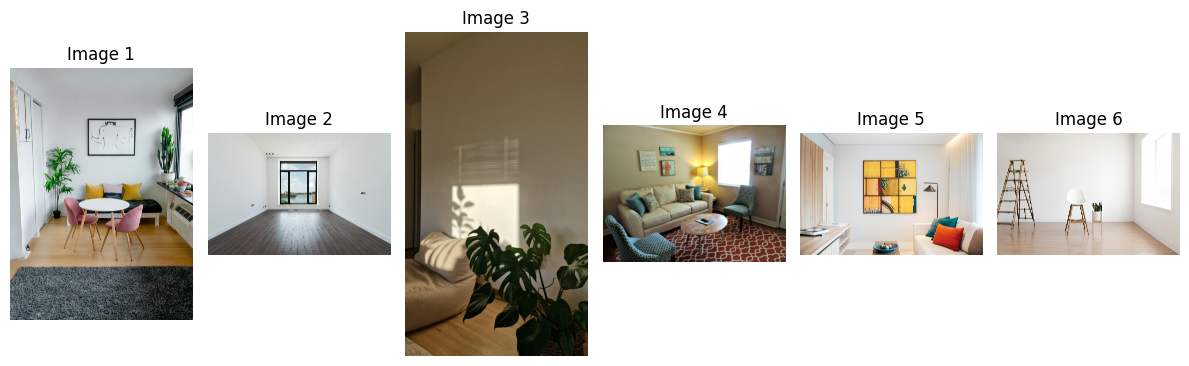

In [8]:
import matplotlib.pyplot as plt

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))])

n_images = min(6, len(image_files))
plt.figure(figsize=(12, 6))
for i in range(n_images):
    img_path = os.path.join(image_dir, image_files[i])
    img = PILImage.open(img_path)
    plt.subplot(1, n_images, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

plt.tight_layout()
plt.show()


## 1. Scene Understanding with a Multimodal LLM

We simulate the behavior of a multimodal large language model (LLM) Google Gemini to describe the uploaded image and extract relevant information for estimating paint needs.

The LLM provides:
- A natural language description of the room
- Reasoned assumptions based on object scale
- An estimated height and width of the wall

> **GenAI Capabilities demonstrated**: Image Understanding + Structured Output (JSON mode)

### Provide a "few-shot" prompt (with example):

In [9]:
prompt = """
You are a virtual renovation assistant. Based on the uploaded image, describe the room and estimate the wall dimensions using visible reference objects (e.g., table, chair, window).

Your response must strictly follow the JSON structure below. Avoid extra assumptions and keep the output concise. All assumptions and estimates must be in **feet** (not meters).

JSON format:
{
  "description": "...",                 // Brief, clear natural language description of the room
  "assumptions": ["..."],              // Max 5 concise assumptions (1 line each, use feet/inches)
  "estimated_dimensions": {
    "height": float,                   // Approximate wall height in feet
    "width": float,                    // Approximate wall width in feet
    "area": float                      // Estimated wall area in square feet
  }
}

Example Response:
{
  "description": "The image shows a living room with off-white walls, beige carpet, and mid-century modern furniture. A green couch, wooden coffee table, and two framed abstract prints are visible.",
  "assumptions": [
    "Standard ceiling height is 8 feet",
    "The couch is about 6 feet long",
    "Framed prints are approximately 2x3 feet each"
  ],
  "estimated_dimensions": {
    "height": 8,
    "width": 12,
    "area": 96
  }
}

Example Response:
{
  "description": "The image depicts an empty room with white walls and light wooden flooring.  A wooden ladder leans against the left wall, while a white bar stool and a potted snake plant sit near the center of the room. A large, bright window is visible on the right wall, filling the space with natural light.",
  "assumptions": [
    "Standard ladder height of approximately 2.5 meters.",
    "Standard bar stool height of approximately 0.75 meters."
  ],
  "estimated_dimensions": {
    "height": 8,
    "width": 19,
    "area": 47
  }
}

Example Response:
{
  "description": "The image shows a room with mustard-yellow walls, a dark wood-look floor, and white baseboards.  A wooden bench sits against the far wall, holding framed art prints, a large clear glass vase with bare branches, and a potted plant.  A partially visible dining table and a white, furry chair are on the left side of the image. A white, pleated pendant lamp hangs from the ceiling.  A potted yucca plant is to the left of the bench, and another plant is on the bench.",
  "assumptions": [
    "Standard ceiling height of approximately 2.4 meters.",
    "The bench is approximately 1 meter long.",
    "The framed prints are standard sizes."
  ],
  "estimated_dimensions": {
    "height": 9,
    "width": 14,
    "area": 30
  }
}


"""


### Define the JSON Schema

In [10]:
class EstimatedDimensions(typing.TypedDict):
    height: float
    width: float
    area: float

class Wall(typing.TypedDict):
    description: str
    assumptions: list[str]
    estimated_dimensions: EstimatedDimensions


### Select and display one of the dataset images to compare it with the generated JSON:

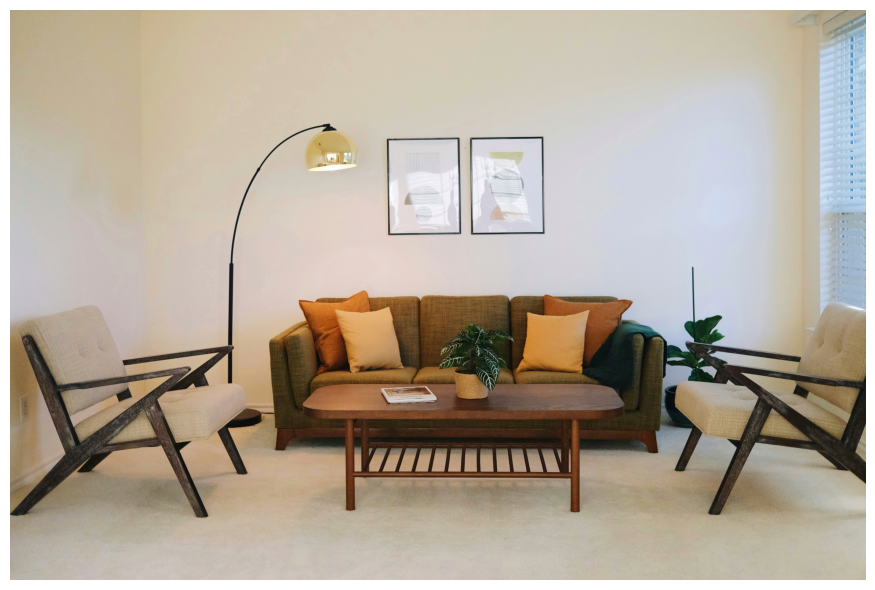

In [11]:
image = PILImage.open(os.path.join(image_dir, 'img6.jpg'))   # <-- try other images!

plt.figure(figsize=(12, 6))
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
client = genai.Client(api_key=GOOGLE_API_KEY)
response = client.models.generate_content(
    model="models/gemini-1.5-pro-latest",
    config=types.GenerateContentConfig(
        temperature=0.1, response_mime_type="application/json", response_schema=Wall),
    contents=[prompt, image]
)
print("\nJSON Output:\n")
print(json.dumps(response.parsed, indent=2, ensure_ascii=False))


JSON Output:

{
  "description": "The image shows a living room with off-white walls, a beige carpet, and mid-century modern furniture.  A green couch, two matching armchairs, a wooden coffee table, a gold arc lamp, and two framed abstract prints are visible. A window with blinds is on the right wall.",
  "assumptions": [
    "Standard ceiling height is 8 feet",
    "The couch is approximately 7 feet long",
    "The coffee table is approximately 4 feet long",
    "Each framed print is approximately 2x3 feet"
  ],
  "estimated_dimensions": {
    "height": 8.0,
    "width": 15.0,
    "area": 120.0
  }
}


### The kind of output we hoped for! The model is generating structured, reasoned, and visually aware responses using Gemini with image input, assumptions, and dimension estimation.

## 2. Build an Agent

We leverage the Function Calling capabilities of Gemini to estimate how much paint is needed for a renovation project based on the dimensions extracted in the previous step.

This step uses a custom-defined function, `calculate_paint`, which takes the wall area, number of coats, and paint coverage efficiency as inputs. Gemini automatically detects when to invoke the function and returns a structured, actionable result.

The function:
- Multiplies the area by the number of coats
- Divides by the coverage rate
- Outputs the total amount of paint required



In [13]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.5 MB/s eta 0:00:00


### 2.1 Build a chatbot as the first Node and main State

In [14]:
# Define the state structure for the LangGraph workflow.
# This determines what data is passed between nodes in the PaintPilot assistant.

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class PaintPilotState(TypedDict):
    """Holds the conversation messages and whether estimation is complete."""
    messages: Annotated[list, add_messages]
    image_path: str
    scene_info: dict
    estimation: dict
    tool_list: dict
    finished: bool

In [15]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from functools import partial

llm = ChatGoogleGenerativeAI(model="models/gemini-1.5-pro-latest", temperature=0.1)

def chatbot(state: PaintPilotState, llm) -> PaintPilotState:
    """Main PaintPilot assistant node. Adds an AI message to the conversation."""

    system_msg = (
        "system",
        "You are PaintPilot, a renovation assistant helping estimate wall dimensions from uploaded images. "
        "If assumptions can't be made confidently from the image, ask the user for clarification — for example, "
        "'What is the ceiling height?' or 'Is this a standard 8 ft wall?' Your answers should be helpful, brief, "
        "and guide the user through estimating surface area for painting."
    )

    if not state["messages"]:
        state["messages"] = [HumanMessage(content="Here is the image I want to analyze.")]
    
    message_history = [system_msg] + state["messages"]
    ai_reply = llm.invoke(message_history)

    return {
        "messages": state["messages"] + [AIMessage(content=ai_reply.content)],
        "image_path": state.get("image_path", ""),
        "scene_info": state.get("scene_info", {}),
        "estimation": state.get("estimation", {}),
        "tool_list": state.get("tool_list", {}),
        "finished": False
    }
    
# Wrap chatbot, so it can be called with 1 argument
chatbot_node = partial(chatbot, llm=llm)


### 2.2: Adding @tools to the Graph

In [16]:
from langchain.tools import tool
import datetime

@tool
def scene_analysis(image_path: str) -> dict:
    """
    Analyze the scene and estimate wall dimensions based on the uploaded image.
    Logs each step for debugging. Returns parsed Gemini output or error.
    """
    print(f"\n[scene_analysis] Called at: {datetime.datetime.now()}")
    print(f"Image path: {image_path}")

    try:
        # Load the image
        image = PILImage.open(image_path)
        print("[scene_analysis] Image loaded successfully.")

        # Call Gemini multimodal model
        response = client.models.generate_content(
            model="models/gemini-1.5-pro-latest",
            config=types.GenerateContentConfig(
                temperature=0.1,
                response_mime_type="application/json",
                response_schema=Wall
            ),
            contents=[prompt, image]
        )

        print("[scene_analysis] Gemini model responded.")
        print(json.dumps(response.parsed, indent=2))
        return response.parsed

    except Exception as e:
        print(f"[scene_analysis] Error: {str(e)}")
        return {"error": str(e)}

In [18]:
from pydantic import BaseModel, Field

class SceneInfoInput(BaseModel):
    scene_info: dict = Field(..., description="The scene analysis output containing estimated_dimensions.")

@tool
def paint_estimator(input: SceneInfoInput) -> dict:
    """
    Estimates the paint needed based on estimated wall area.
    Assumes 2 coats and 10 m²/L coverage by default.
    """
    try:
        dims = input.scene_info.get("estimated_dimensions", {})
        if not all(k in dims for k in ("height", "width", "area")):
            return {"error": "Missing or malformed estimated_dimensions."}

        area_ft2 = dims["area"]
        coats = 2  # default
        coverage_m2_l = 10.0
        paint_liters = (area_ft2 * coats) / coverage_m2_l

        area_m2 = area_ft2 / 10.764
        paint_gallons = paint_liters / 3.78541
        coverage_ft2_gal = round(coverage_m2_l * 10.764 * 3.78541, 1)

        return {
            "area_ft2": round(area_ft2, 2),
            "area_m2": round(area_m2, 2),
            "paint_gallons": round(paint_gallons, 2),
            "paint_liters": round(paint_liters, 2),
            "coats": coats,
            "coverage_ft2_gal": coverage_ft2_gal,
            "coverage_m2_l": coverage_m2_l
        }

    except Exception as e:
        return {"error": f"Paint estimate failed: {str(e)}"}


In [19]:
@tool
def tool_and_material_estimator(estimation: dict) -> dict:
    """
    Returns a checklist of tools and materials based on the paint estimation.
    """
    try:
        area = estimation.get("area_m2", 0)
        coats = estimation.get("coats", 2)

        tools = {
            "paint_gallons": estimation.get("paint_gallons", 0),
            "rollers": 1 if area < 50 else 2,
            "brushes": 2,
            "painter_tape_rolls": 1 if area < 30 else 2,
            "paint_trays": 1,
            "drop_cloths": 1 if area < 20 else 2,
            "ladder": True if area > 25 else False
        }

        return tools

    except Exception as e:
        return {"error": f"Tool & material estimation failed: {str(e)}"}


In [20]:
from langchain_core.messages import HumanMessage, AIMessage

def chatbot_summary(state: PaintPilotState, llm) -> PaintPilotState:
    """LLM-based summary of the full paint and tool estimate with helpful tips."""

    # Extract state info
    tool_list = state.get("tool_list", {})
    est = state.get("estimation", {})
    scene_dims = state.get("scene_info", {}).get("estimated_dimensions", {})

    # Pull basic values
    area = est.get("area_ft2", "unknown")
    height = scene_dims.get("height", "?")
    width = scene_dims.get("width", "?")
    coats = est.get("coats", 2)
    liters = est.get("paint_liters", "?")
    gallons = est.get("paint_gallons", "?")

    # Build tool summary text
    tool_lines = [f"- {k.replace('_', ' ').capitalize()}: {v}" for k, v in tool_list.items() if v]
    tool_text = "\n".join(tool_lines)

    # Craft prompt for LLM
    prompt = f"""
You are PaintPilot, a renovation assistant helping users estimate painting needs.

Write a friendly and helpful summary message based on the following:

- Wall area: {area} ft² (approx. {height} ft × {width} ft)
- {coats} coats of paint
- Estimated paint: {liters} liters ({gallons} gallons)
- Tool checklist:
{tool_text}

Explain how the paint amount was calculated (area × coats ÷ coverage).
Finish with a short painting tip (e.g., tape edges, lay cloths, clean surfaces).
"""

    ai_reply = llm.invoke([HumanMessage(content=prompt)])

    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=ai_reply.content)],
        "finished": True
    }


# Wrap it using partial to pass `llm`
chatbot_summary_node = partial(chatbot_summary, llm=llm)

### 2.3 Build the Graph

In [21]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph, START, END

# -- Wrap tool functions in RunnableLambda --
scene_analysis_node = RunnableLambda(lambda state: (
    print("scene_analysis_node executed"),
    {
        **state,
        "scene_info": scene_analysis.invoke(state["image_path"])

    }
)[1])

paint_estimator_node = RunnableLambda(lambda state: (
    print("paint_estimator_node executed"),
    {
        **state,
        "estimation": paint_estimator.invoke({"input": {"scene_info": state["scene_info"]}})
    }
)[1])

tool_estimator_node = RunnableLambda(lambda state: (
    print("tool_estimator_node executed"),
    {
        **state,
        "tool_list": tool_and_material_estimator.invoke({"estimation": state["estimation"]})
    }
)[1])



graph = StateGraph(PaintPilotState)

graph.add_node("chatbot", chatbot_node)
graph.add_node("scene_analysis", scene_analysis_node)
graph.add_node("paint_estimator", paint_estimator_node)
graph.add_node("tool_estimator", tool_estimator_node)
graph.add_node("chatbot_summary", chatbot_summary_node)

graph.set_entry_point("chatbot")
graph.add_edge("chatbot", "scene_analysis")
graph.add_edge("scene_analysis", "paint_estimator")
graph.add_edge("paint_estimator", "tool_estimator")
graph.add_edge("tool_estimator", "chatbot_summary")
graph.add_edge("chatbot_summary", END)

# Run the Graph
app = graph.compile()

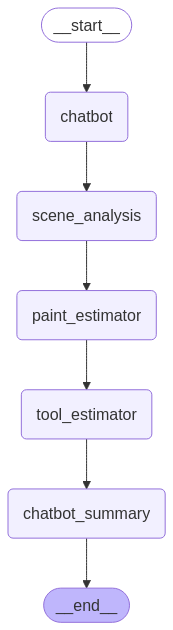

In [22]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())


### 2.4 Test

In [23]:
# define the input: initial_state
initial_state = {
    "messages": [],
    "image_path": os.path.join(image_dir, 'img6.jpg'),  # <-- Replace with another test image
    "scene_info": {},
    "estimation": {},
    "tool_list": {},
    "finished": False
}

In [24]:
# Run the Graph
final_state = app.invoke(initial_state)

scene_analysis_node executed

[scene_analysis] Called at: 2025-04-20 00:43:57.785953
Image path: /kaggle/input/interior-wall-samples/img6.jpg
[scene_analysis] Image loaded successfully.
[scene_analysis] Gemini model responded.
{
  "description": "The image shows a living room with off-white walls, a beige carpet, and mid-century modern furniture.  A green couch, two matching armchairs, a wooden coffee table, and a gold arc lamp are visible. Two framed abstract prints hang on the wall behind the couch. A window with blinds is visible on the right.",
  "assumptions": [
    "Standard ceiling height is 8 feet",
    "The couch is approximately 6 feet long",
    "The coffee table is approximately 3 feet long",
    "Each framed print is approximately 2x3 feet"
  ],
  "estimated_dimensions": {
    "height": 8.0,
    "width": 15.0,
    "area": 120.0
  }
}
paint_estimator_node executed
tool_estimator_node executed


In [25]:
print("=== Final Chatbot Summary ===")
print(final_state["messages"][-1].content)

=== Final Chatbot Summary ===
Hi there! Based on your wall dimensions of approximately 8.0 ft by 15.0 ft, you have a total wall area of about 120.0 ft².  Since you're planning on two coats, you'll need approximately 24.0 liters (6.34 gallons) of paint.  This is calculated by multiplying the area (120.0 ft²) by the number of coats (2) and then dividing by the standard coverage of paint, which is typically around 300 ft²/gallon (this can vary slightly depending on the paint type, so check your paint can).

Here's your tool checklist to make sure you're all set:

* Paint: 6.34 gallons
* Rollers: 1
* Brushes: 2
* Painter's Tape Rolls: 1
* Paint Trays: 1
* Drop Cloths: 1

Painting Tip: Before you start, make sure to thoroughly clean your walls to remove any dust or debris. This will help the paint adhere better and give you a smoother, more professional finish. Happy painting! 


In [26]:
print("=== Tool & Material Checklist ===")
print(json.dumps(final_state["tool_list"], indent=2))

=== Tool & Material Checklist ===
{
  "paint_gallons": 6.34,
  "rollers": 1,
  "brushes": 2,
  "painter_tape_rolls": 1,
  "paint_trays": 1,
  "drop_cloths": 1,
  "ladder": false
}


### Test complete
At this point, the pipeline should be fully functional. You can swap `img6.jpg` in the test payload with other filenames to try different images.

## 3. Evaluate the Assistant Output

To assess the quality of the final assistant response, we apply structured GenAI Evaluation using Gemini’s language understanding and structured output capabilities.

We define a custom evaluator that examines the assistant's summary message based on four key criteria: instruction following, helpfulness, completeness, and fluency. The evaluation is performed in two stages:
- First, Gemini provides a step-by-step justification of its assessment
- Then, it converts the final judgment into a structured rating, using a 1–5 scoring scale
- This approach allows us to automatically measure the effectiveness of the assistant’s output and demonstrate a clear example of GenAI-based evaluation in practice.

In [27]:
import enum
from google.genai import types

class PaintSummaryRating(enum.Enum):
    VERY_GOOD = '5'
    GOOD = '4'
    OK = '3'
    BAD = '2'
    VERY_BAD = '1'

In [28]:
PAINT_SUMMARY_EVAL_PROMPT = """
# Instruction
You are a helpful evaluator. Your task is to assess the quality of a paint project summary generated by an AI assistant.
The summary should help the user prepare for a painting task based on the tool list, and it should be easy to understand, well-organized, and complete.

# Evaluation Criteria
1. Instruction following: Does the summary clearly reflect the tools provided?
2. Helpfulness: Would a non-expert understand what to do next?
3. Completeness: Are any essential items missing from the advice?
4. Fluency: Is the response natural, well-written, and easy to read?

# Rating Rubric
5: (Very good). Clear, complete, and perfectly helpful.
4: (Good). Minor issues, but still helpful and clear.
3: (Ok). Somewhat helpful but lacking completeness or clarity.
2: (Bad). Not helpful or missing key content.
1: (Very bad). Confusing or wrong.

# Format
Please output a short justification, followed by a score.
"""


In [29]:
def evaluate_summary(summary_text: str):
    print("\n=== EVALUATION INPUT ===")
    print(summary_text)

    # Start a Gemini chat session
    chat = client.chats.create(model="gemini-1.5-pro-latest")
    
    # Send evaluation instructions
    response = chat.send_message(PAINT_SUMMARY_EVAL_PROMPT + "\n\n" + summary_text)
    verbose_eval = response.text
    print("\n=== VERBOSE FEEDBACK ===")
    print(verbose_eval)

    # Get structured enum score
    structured_output_config = types.GenerateContentConfig(
        response_mime_type="text/x.enum",
        response_schema=PaintSummaryRating,
    )
    response = chat.send_message("Convert your final score to enum value.", config=structured_output_config)
    structured_score = response.parsed
    print("\n=== STRUCTURED SCORE ===")
    print(structured_score.name)

    return verbose_eval, structured_score


In [30]:
evaluation_feedback, evaluation_score = evaluate_summary(final_state["messages"][-1].content)



=== EVALUATION INPUT ===
Hi there! Based on your wall dimensions of approximately 8.0 ft by 15.0 ft, you have a total wall area of about 120.0 ft².  Since you're planning on two coats, you'll need approximately 24.0 liters (6.34 gallons) of paint.  This is calculated by multiplying the area (120.0 ft²) by the number of coats (2) and then dividing by the standard coverage of paint, which is typically around 300 ft²/gallon (this can vary slightly depending on the paint type, so check your paint can).

Here's your tool checklist to make sure you're all set:

* Paint: 6.34 gallons
* Rollers: 1
* Brushes: 2
* Painter's Tape Rolls: 1
* Paint Trays: 1
* Drop Cloths: 1

Painting Tip: Before you start, make sure to thoroughly clean your walls to remove any dust or debris. This will help the paint adhere better and give you a smoother, more professional finish. Happy painting! 

=== VERBOSE FEEDBACK ===
Justification: The summary is well-written and helpful, covering key aspects like paint calc

### Evaluation Summary

Our assistant’s final message received a **4 out of 5**. A strong result with clear and actionable feedback. The summary was well-written and helpful, but it could be further improved by mentioning optional prep steps like using a primer *if needed!*, or including basic cleaning materials. It also missed specifying the **type of paint**, which can be important depending on the surface and context.

This evaluation shows we're on the right track, and even small refinements can push the assistant toward a perfect score. With a few thoughtful enhancements, we’re excited to make the PaintPilot experience even better!



---